In [1]:
# License: BSD
# Author: Sasank Chilamkurthy

%matplotlib inline
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import torchsample
from torchsample import transforms as ts_transforms
import matplotlib.pyplot as plt
import time
import copy
import os
from PIL import Image
from tensorboard import SummaryWriter
from datetime import datetime
import importlib

from torchsample.transforms import RangeNorm

import functions.fine_tune as ft

plt.ion()   # interactive mode

/home/mtezcan/anaconda3/lib/python3.6/site-packages/torchsample-0.1.2-py3.6.egg/torchsample/datasets.py:16: UserWarning: Cant import nibabel.. Cant load brain images


Load Data
---------



In [2]:
# Data augmentation and normalization for training 
# Just normalization for validation
#uniform_sampler=False
batch_size=64
split=1000
random_seed=1
shuffle=True

data_transforms = {
    'train': transforms.Compose([
        transforms.Scale(256),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        #ts_transforms.RandomRotate(30)
    ]),
    'val': transforms.Compose([
        transforms.Scale(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/media/mtezcan/New Volume/amazon/images/0to5'
#data_dir = '/home/mtezcan/Documents/amazon/bin_images/0to5'
dset_train = datasets.ImageFolder(data_dir, data_transforms['train'])
dset_val = datasets.ImageFolder(data_dir, data_transforms['val'])

num_train = len(dset_train)
indices = list(range(num_train))

valid_idx=[220806, 101502, 106342, 66781, 277538, 153390, 85150, 73999, 83399, 271460, 354587, 353369, 209657, 155119, 200581, 326737, 124537, 286296, 302778, 250835, 15112, 245211, 108957, 75425, 145986, 230962, 274927, 187674, 71411, 249051, 252381, 44201, 184754, 112440, 229215, 282498, 239779, 336054, 54866, 256004, 169846, 185929, 279043, 346604, 192325, 73623, 331979, 55305, 273496, 148421, 197056, 139122, 34876, 113384, 146648, 187275, 139007, 311499, 249972, 164472, 43106, 23408, 243698, 359383, 240862, 101066, 172719, 161909, 118189, 287270, 89637, 352585, 148921, 97531, 40765, 319020, 71864, 96424, 56370, 140971, 85946, 233865, 65679, 230728, 193480, 123715, 124074, 293119, 227885, 82886, 35191, 99525, 144313, 200043, 38290, 2833, 147723, 165010, 234131, 328228, 251770, 131699, 69825, 23583, 79289, 87843, 354172, 26824, 309220, 59371, 300096, 208340, 231984, 81240, 190137, 176267, 183585, 162745, 42665, 69601, 356472, 167684, 87336, 119884, 141296, 50335, 142120, 56317, 185846, 269697, 283046, 356931, 219754, 43169, 221830, 60065, 272330, 49656, 124196, 101389, 57645, 236367, 151859, 203621, 264710, 228887, 71255, 8207, 36158, 199741, 137692, 258241, 141793, 244457, 194203, 40965, 144727, 153824, 28923, 241160, 4703, 1107, 236877, 225023, 204994, 237336, 286449, 308870, 286606, 328058, 237232, 149831, 16814, 109416, 101545, 360328, 361409, 85621, 116139, 162617, 46042, 189809, 336247, 226459, 176159, 191841, 272239, 276008, 212090, 161507, 134730, 246708, 77745, 291092, 202658, 165808, 287707, 110951, 64400, 156687, 5235, 178584, 355620, 227953, 251307, 325540, 208435, 321359, 253713, 256830, 279452, 181261, 15973, 355893, 348863, 166229, 69819, 56141, 124360, 181018, 170915, 326375, 126714, 300167, 144281, 264347, 4126, 14643, 136059, 350885, 227856, 117898, 313218, 151227, 231255, 32792, 181003, 202900, 340520, 11500, 315574, 264864, 136013, 289934, 70064, 257402, 241433, 34452, 185058, 157818, 356800, 199148, 101941, 267090, 311143, 219266, 32092, 27228, 349518, 231085, 197210, 26369, 233464, 235369, 20823, 199348, 299896, 107442, 347353, 15286, 155230, 155172, 37018, 179960, 343419, 102990, 347763, 98758, 90403, 227440, 318400, 196957, 195855, 58782, 213797, 87850, 22548, 211139, 62988, 4958, 150494, 361695, 260959, 347243, 209613, 149005, 55485, 132360, 182654, 324380, 83376, 43528, 301271, 156521, 179398, 55266, 146109, 306181, 353401, 101325, 350102, 241011, 216433, 29971, 348396, 92538, 186371, 144328, 341336, 301089, 94262, 97603, 187922, 126073, 303392, 270496, 277848, 268380, 247076, 176349, 64457, 88043, 148628, 170404, 231365, 194105, 285247, 95052, 51245, 249936, 164099, 5238, 289112, 116978, 174294, 303784, 144800, 89563, 155200, 74687, 79475, 326602, 150416, 4094, 305064, 302788, 194657, 205509, 361264, 304749, 20312, 271557, 221827, 354438, 94088, 74429, 60627, 77896, 160525, 106910, 176491, 139942, 275005, 10430, 2099, 56654, 352531, 17241, 157679, 234336, 91897, 296246, 104239, 252009, 241589, 340121, 106932, 346913, 260436, 21986, 174457, 335131, 361531, 259265, 230243, 157423, 161942, 227857, 154879, 268170, 105543, 291619, 352220, 156994, 24283, 282026, 7241, 86960, 120182, 122717, 134729, 155687, 350956, 100982, 54064, 221834, 279232, 94172, 199317, 268458, 296678, 213026, 8489, 313506, 343416, 85867, 215581, 361236, 25792, 53980, 133065, 163872, 225909, 150527, 88533, 249337, 77056, 292408, 234622, 59750, 351626, 299201, 116486, 251856, 97645, 238537, 345975, 17877, 100223, 183698, 21083, 48218, 143866, 284418, 156560, 358339, 279714, 256423, 307961, 261801, 295715, 230198, 321487, 308382, 106380, 147420, 356142, 342499, 59673, 6820, 288497, 312996, 326367, 69364, 31444, 11908, 148312, 232148, 169024, 172764, 121910, 161986, 282865, 11796, 144579, 191425, 154643, 340065, 133114, 64296, 309608, 104730, 52243, 307625, 148265, 27005, 23280, 233012, 139739, 21520, 94482, 247734, 128786, 318115, 311838, 341658, 221846, 77141, 78791, 252507, 335976, 338500, 90551, 192682, 142346, 308525, 352732, 334969, 123686, 313773, 210610, 94541, 296663, 329024, 301726, 11334, 48960, 93775, 183412, 118819, 310383, 287280, 148450, 50611, 292591, 207049, 255223, 322893, 302262, 194648, 27941, 66201, 67478, 17537, 272679, 262221, 346115, 295165, 337900, 295867, 247645, 243861, 98760, 292561, 156712, 399, 32521, 205456, 199037, 209942, 158106, 154861, 70288, 231354, 197631, 112676, 29587, 91227, 74151, 296883, 14131, 152056, 348717, 349252, 259664, 256989, 236023, 162736, 83314, 262588, 163637, 70431, 101509, 241458, 133676, 347139, 354032, 102481, 178343, 82861, 212448, 82824, 239380, 226037, 203522, 341284, 165052, 286317, 39054, 65947, 69784, 161562, 82849, 111214, 267860, 40015, 214636, 207532, 268826, 231194, 164653, 223146, 180564, 86436, 161863, 357162, 20343, 82644, 83436, 318903, 140631, 50244, 233869, 166864, 340499, 225900, 142344, 269242, 166393, 354656, 242037, 282340, 101381, 332742, 286843, 189721, 164017, 158092, 17496, 5025, 265305, 209223, 269902, 251823, 246498, 299399, 223389, 42207, 44142, 324277, 100129, 111660, 351779, 6452, 322573, 121941, 33079, 218248, 78638, 75306, 152232, 345325, 160408, 342094, 328497, 289494, 172422, 310978, 199819, 249863, 12711, 31631, 37190, 263083, 75404, 259857, 316759, 38544, 182949, 113566, 146656, 241747, 298281, 257270, 36066, 87852, 305389, 139779, 210721, 356641, 267955, 258853, 254248, 308907, 287605, 216716, 238589, 217546, 254036, 89911, 43001, 52875, 358214, 148594, 49097, 200334, 159299, 4105, 102893, 43405, 270144, 137159, 340636, 261219, 354677, 357319, 155263, 183251, 61389, 245219, 265336, 191970, 351201, 156955, 273695, 251557, 55157, 125156, 62030, 39368, 270137, 274708, 127536, 329384, 15259, 161962, 57236, 163313, 14247, 242779, 6397, 14504, 139106, 109032, 69706, 110939, 20738, 13251, 74858, 330149, 297574, 30426, 280848, 317204, 204041, 50893, 283271, 215518, 207823, 282057, 70381, 342285, 226069, 55225, 66697, 293640, 173798, 218090, 52564, 158812, 154568, 113949, 134635, 353952, 45985, 229552, 23376, 46429, 80026, 11034, 139263, 208109, 256447, 35873, 165358, 163288, 74225, 243721, 250989, 105156, 266447, 88504, 9616, 213911, 207388, 82184, 303531, 223415, 320506, 78537, 179172, 119681, 359713, 121873, 342733, 251879, 299001, 314075, 66825, 342330, 223927, 355755, 206803, 285416, 256810, 170335, 35150, 177518, 151916, 162254, 330014, 198723, 7401, 158320, 122561, 226395, 237177, 318107, 277761, 155280, 32786, 192952, 243279, 149735, 182394, 263432, 326316, 138754, 174159, 198733, 68521, 132701, 295264, 309712, 203763, 96735, 66984, 163273, 6119, 320775, 45308, 154433, 35909, 208417, 310967, 176259, 243407, 295304, 339946, 109233, 48379, 92320, 147262, 75474, 18219, 306661, 253305, 119191, 118573, 276815, 265177, 331965, 157396, 72832, 316142, 43286, 178205, 33320, 359565, 269858, 233013, 130272, 272158, 75437, 31095, 357176, 93276, 228918, 65931, 61460, 208111, 87621, 79690, 258846, 345688, 1191, 283079, 200622, 262659, 278749, 214467, 286217, 320300, 317499, 211547, 178071, 138845, 10346, 145785, 201537, 286251, 11593, 159892, 234628, 199150, 116993, 221617, 62411, 149277, 239466, 53888, 50524, 278460, 207156, 213856, 79902, 37827, 212779, 291438, 190677, 214322, 250142, 192449, 52125, 233541, 114120, 136032, 135274, 355921, 121574, 16644, 305495, 65001, 1249, 69651, 220870, 135847, 190622, 166895, 334266, 324825, 73958, 239332, 299636, 276053, 311449, 64518, 322126, 92711, 52106, 326932, 208199, 208777, 287324, 40313, 123053, 317550, 201897, 222207, 331228, 151252, 286583, 77429, 168180, 186146, 114313, 306249, 354395, 228913, 242103, 174051, 39961, 91582, 57836, 248679, 86045, 161763, 225383, 11743, 163166, 350239, 1433, 148444, 335440, 315035, 26751, 341551, 317628, 247362, 296348]
train_idx=np.setdiff1d(indices,valid_idx)
'''
if shuffle == True:
    np.random.seed(random_seed)
    np.random.shuffle(indices)

train_idx, valid_idx = indices[split:], indices[:split]'''
sampler_train = torch.utils.data.sampler.SubsetRandomSampler(train_idx)
sampler_val = torch.utils.data.sampler.SubsetRandomSampler(valid_idx)


dset_loaders = {'train':torch.utils.data.DataLoader(dset_train, batch_size=batch_size,sampler=sampler_train,
                                                    num_workers=12),
                'val':torch.utils.data.DataLoader(dset_val, batch_size=batch_size,sampler=sampler_val,
                                                    num_workers=12)}
'''if(uniform_sampler):
    weights,wpc = ft.make_weights_for_balanced_classes(dsets['train'].imgs, len(dsets['train'].classes))  
    weights = torch.DoubleTensor(weights) 
    sampler = {'train':torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights)) ,
               'val':None}
else:
    sampler = {'train':None,
               'val':None}'''

'''dset_sizes = {x: len(dsets[x]) for x in ['train', 'val']}

print(dset_classes)'''

dset_sizes={'train':len(dset_train)-1000,'val':1000}
dset_classes = dset_train.classes
print(dset_classes)
use_gpu = torch.cuda.is_available()

#use_gpu=False
if use_gpu:
    print('GPU is available')
else:
    print('!!!!! NO CUDA GPUS DETECTED')

['0', '1', '2', '3', '4', '5']
GPU is available


In [8]:
print(dset_sizes)

{'train': 360967, 'val': 1000}


Visualize a few images
^^^^^^^^^^^^^^^^^^^^^^
Let's visualize a few training images so as to understand the data
augmentations.



Size of the input tensors in one batch after grid is  torch.Size([3, 1810, 906])


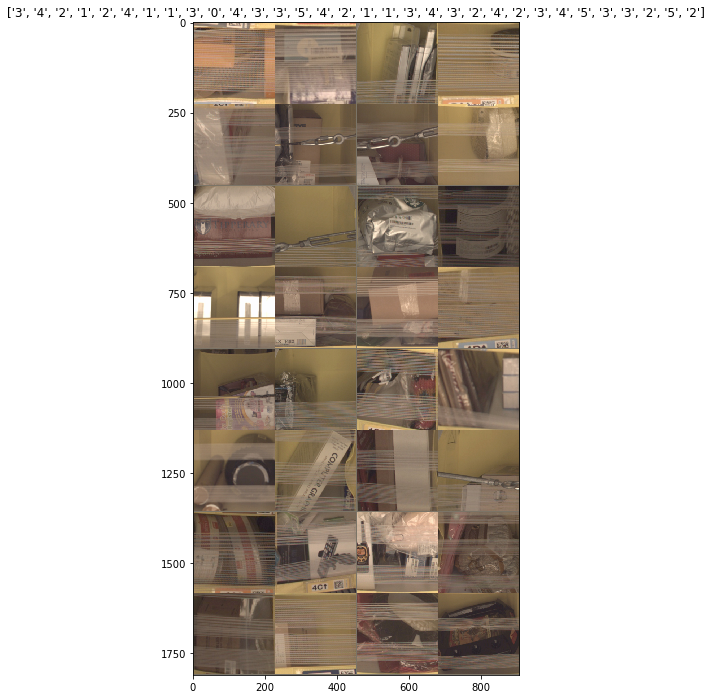

In [6]:

inputs, classes = next(iter(dset_loaders['val']))
#print(classes.cpu().numpy().reshape(4,4)+1)
# Make a grid from batch
out = torchvision.utils.make_grid(inputs,nrow=4)
print('Size of the input tensors in one batch after grid is  '+str(out.size()))
plt.figure(figsize=(12,12))
ft.imshow(out, title=[dset_classes[x] for x in classes])

Finetuning the convnet
----------------------

Load a pretrained model and reset final fully connected layer.




In [3]:
def writeLog(logname):
    f=open('runs/'+logname+'/Network_properties.txt','w')
    f.write('Batch size: '+str(batch_size)+'\n')
    f.write('Validation size: '+str(split)+'\n')
    f.write('Random seed: '+str(random_seed)+'\n')
    f.write('Shuffle: '+str(shuffle)+'\n')
    f.write('Validation size: '+str(split)+'\n')
    f.write('Network: '+network+'\n')
    if mse_loss:
        crt='MSE'
    else:
        crt=str(cross_loss)+'xcross + '+str(multi_loss)+'Xmulti'
    f.write('Criterion: '+crt+'\n')
    f.write('Learning rate: '+str(lr)+'\n')
    f.write('Momentum: '+str(momentum)+'\n')
    f.write('Leraning Rate Scheduler: '+str(lr_scheduler)+'\n')
    f.write('Leraning Rate Decay Period: '+str(lr_decay_epoch)+'\n')
    f.write('Network is pretrained: '+str(pretrained)+'\n')
    f.write('Network laoded from: '+networkName+'\n')
    f.write('MSE loss function: '+str(mse_loss)+'\n')
    f.close()

In [4]:
import openpyxl
import time


'''iter_loc=12
book = openpyxl.load_workbook('logs.xlsx')
sheet = book.active
sheet.append((1,2,3,4,5,6,7,8,9))
n=sheet.max_row
sheet.cell(row=n,column=7).value=123

book.save('logs.xlsx')'''

def writeLog_xlsx(logname='logs.xlsx',iter_loc=14):
    book = openpyxl.load_workbook(logname)
    sheet = book.active
    if mse_loss:
        crt='MSE'
    else:
        crt=str(cross_loss)+'xcross + '+str(multi_loss)+'Xmulti'
    if network=='loaded':
        specs=(datetime.now().strftime('%B%d  %H:%M:%S'),networkName,str(split),str(random_seed),str(shuffle),
               optimizer, crt,str(lr),str(momentum),str(lr_scheduler),str(lr_decay_epoch),str(pretrained),
               str(batch_size))
    else:
        specs=(datetime.now().strftime('%B%d  %H:%M:%S'),network,str(split),str(random_seed),str(shuffle),
               optimizer, crt,str(lr),str(momentum),str(lr_scheduler),str(lr_decay_epoch),str(pretrained),
               str(batch_size))
    sheet.append(specs)
    current_row = sheet.max_row
    sheet.cell(row=current_row, column=iter_loc+5).value = comment
    #n=sheet.max_row
    #sheet.cell(row=n,column=7).value=123
    book.save(logname)
#writeLog_xlsx()

In [5]:
comment=' ' #'Tested for three rooms'
network='resnet34'
networkName='resnet18_real_sgd_multisoft_August29  19:06:27'
optimizer='sgd'
criteria='multisoft'
iter_loc=14
end_to_end=True
lr=0.01
momentum=0.9
weight_decay=0.0005
lr_scheduler=ft.exp_lr_scheduler
lr_decay_epoch=10
pretrained=True
mse_loss=False
nclasses=6
cross_loss=1.
multi_loss=0.

def network_loader(comment=comment, #'Tested for three rooms'
                    network=network,
                    networkName=networkName,
                    optimizer=optimizer,
                    criteria=criteria,
                    iter_loc=iter_loc,
                    end_to_end=end_to_end,
                    lr=lr,
                    momentum=momentum,
                    weight_decay=weight_decay,
                    lr_scheduler=lr_scheduler,
                    lr_decay_epoch=lr_decay_epoch,
                    pretrained=pretrained,
                    mse_loss=mse_loss,
                    nclasses=nclasses):

    if(criteria=='crossentropy'):
        multilabel=False
    else:
        multilabel=True

    if(network=='resnet18'):
        model_ft = models.resnet18(pretrained=pretrained)
        if not end_to_end:
            for param in model_ft.parameters():
                param.requires_grad = False 
        num_ftrs = model_ft.fc.in_features
        if(mse_loss):
            model_ft.fc = nn.Linear(num_ftrs, 1)
        else:    
            model_ft.fc = nn.Linear(num_ftrs, nclasses)
    elif(network=='resnet34'):
        model_ft = models.resnet34(pretrained=pretrained)
        if not end_to_end:
            for param in model_ft.parameters():
                param.requires_grad = False 
        num_ftrs = model_ft.fc.in_features
        if(mse_loss):
            model_ft.fc = nn.Linear(num_ftrs, 1)
        else:    
            model_ft.fc = nn.Linear(num_ftrs, nclasses)
    elif(network=='resnet50'):
        model_ft = models.resnet50(pretrained=pretrained)
        if not end_to_end:
            for param in model_ft.parameters():
                param.requires_grad = False 
        num_ftrs = model_ft.fc.in_features
        if(mse_loss):
            model_ft.fc = nn.Linear(num_ftrs, 1)
        else:    
            model_ft.fc = nn.Linear(num_ftrs, nclasses)
    elif(network=='resnet101'):
        model_ft = models.resnet101(pretrained=pretrained)
        if not end_to_end:
            for param in model_ft.parameters():
                param.requires_grad = False 
        num_ftrs = model_ft.fc.in_features
        if(mse_loss):
            model_ft.fc = nn.Linear(num_ftrs, 1)
        else:    
            model_ft.fc = nn.Linear(num_ftrs, nclasses)
    elif(network=='alexnet'):
        model_ft = models.alexnet(pretrained=pretrained)
        num_ftrs = model_ft.classifier[6].out_features
        setattr(model_ft.classifier, '7', nn.ReLU(inplace=True))
        setattr(model_ft.classifier, '8', nn.Dropout())
        setattr(model_ft.classifier, '9', nn.Linear(num_ftrs,nclasses))
    elif(network=='loaded'):
        model_ft = torch.load('./saved_models/'+networkName)
        if not end_to_end:
            for param in model_ft.parameters():
                param.requires_grad = False 
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, nclasses)
    else:
        raise ValueError('Undefined network '+network)

    if use_gpu:
        model_ft = model_ft.cuda()

    if(criteria=='crossentropy'):
        criterion = nn.CrossEntropyLoss()
    elif(criteria=='multisoft'):
        criterion=nn.MultiLabelSoftMarginLoss()
    else:
        raise ValueError('Undefined criteria '+criteria)

    if(optimizer=='adam'):
        optimizer_ft = optim.Adam(model_ft.parameters(),lr=lr,weight_decay=weight_decay)
    elif(optimizer=='sgd'):
        if(end_to_end):
            optimizer_ft = optim.SGD(model_ft.parameters(), lr=lr, momentum=momentum)#,weight_decay=weight_decay)
        else:
            optimizer_ft = optim.SGD(model_ft.fc.parameters(), lr=lr, momentum=momentum,weight_decay=weight_decay)
    return model_ft, optimizer_ft, criterion, multilabel

In [6]:
importlib.reload(ft)

def run_network():
    model_ft, optimizer_ft, criterion, multilabel = network_loader(comment=comment, #'Tested for three rooms'
                                                                    network=network,
                                                                    networkName=networkName,
                                                                    optimizer=optimizer,
                                                                    criteria=criteria,
                                                                    iter_loc=iter_loc,
                                                                    end_to_end=end_to_end,
                                                                    lr=lr,
                                                                    momentum=momentum,
                                                                    weight_decay=weight_decay,
                                                                    lr_scheduler=lr_scheduler,
                                                                    lr_decay_epoch=lr_decay_epoch,
                                                                    pretrained=pretrained,
                                                                    mse_loss=mse_loss,
                                                                    nclasses=nclasses)
    
    if mse_loss:
        crt='MSE'
    else:
        crt=str(cross_loss)+'xcross + '+str(multi_loss)+'Xmulti'
    logname=network+'_'+'_'+optimizer+'_'+crt+'_'+datetime.now().strftime('%B%d  %H:%M:%S')
    writer = SummaryWriter('runs/'+logname)
    writeLog(logname)
    writeLog_xlsx()
    '''model_ft = ft.train_model(model_ft, criterion, optimizer_ft, lr_scheduler,dset_loaders,dset_sizes,writer,
                            use_gpu=use_gpu,num_epochs=50,batch_size=batch_size,num_log=50,multilabel=multilabel,
                              multi_prob=False,lr_decay_epoch=lr_decay_epoch,init_lr=lr,mse_loss=False,
                              iter_loc=iter_loc)'''

    best_model, last_model = ft.train_model(model_ft, criterion, optimizer_ft, lr_scheduler,dset_loaders,
                            dset_sizes,writer,
                            use_gpu=use_gpu,num_epochs=30,batch_size=batch_size,num_log=250,multilabel=multilabel,
                              multi_prob=False,lr_decay_epoch=lr_decay_epoch,init_lr=lr,mse_loss=mse_loss,
                              iter_loc=iter_loc,cross_loss=cross_loss,multi_loss=multi_loss)
    torch.save(best_model,'./saved_models/'+logname+'_best')
    torch.save(last_model,'./saved_models/'+logname+'_last')
    del model_ft




In [7]:
mse_loss=False
cross_loss=1.
multi_loss=0.
run_network()

Epoch 0/29
----------
LR is set to 0.01
250/5641, acc: 0.3142, CIR-1: 0.7411, RMSE: 1.3471
500/5641, acc: 0.3352, CIR-1: 0.7660, RMSE: 1.2904
750/5641, acc: 0.3495, CIR-1: 0.7830, RMSE: 1.2492
1000/5641, acc: 0.3624, CIR-1: 0.7923, RMSE: 1.2279
1250/5641, acc: 0.3689, CIR-1: 0.7984, RMSE: 1.2138
1500/5641, acc: 0.3756, CIR-1: 0.8040, RMSE: 1.1992
1750/5641, acc: 0.3791, CIR-1: 0.8069, RMSE: 1.1909
2000/5641, acc: 0.3839, CIR-1: 0.8094, RMSE: 1.1859
2250/5641, acc: 0.3881, CIR-1: 0.8126, RMSE: 1.1781
2500/5641, acc: 0.3921, CIR-1: 0.8154, RMSE: 1.1706
2750/5641, acc: 0.3948, CIR-1: 0.8177, RMSE: 1.1651
3000/5641, acc: 0.3979, CIR-1: 0.8194, RMSE: 1.1608
3250/5641, acc: 0.4007, CIR-1: 0.8210, RMSE: 1.1562
3500/5641, acc: 0.4035, CIR-1: 0.8227, RMSE: 1.1513
3750/5641, acc: 0.4057, CIR-1: 0.8243, RMSE: 1.1478
4000/5641, acc: 0.4079, CIR-1: 0.8254, RMSE: 1.1446
4250/5641, acc: 0.4099, CIR-1: 0.8263, RMSE: 1.1416
4500/5641, acc: 0.4123, CIR-1: 0.8279, RMSE: 1.1375
4750/5641, acc: 0.4139, CIR

In [7]:
mse_loss=True
optimizer='adam'
network='resnet18'

for learning in [ 0.01, 0.03, 0.05, 0.1]:
    lr=learning
    run_network()
    
optimizer='sgd'
for learning in [0.01, 0.03,0.05, 0.1]:
    lr=learning
    run_network()
    
    
mse_loss=False
optimizer='sgd'
network='resnet18'
cross_loss=1.0

for learning in [ 0.005, 0.01, 0.05]:
    for ml in [.3,.6,1.0,1.5,2.0,5.0,10.0]:
        multi_loss=ml
        lr=learning
        run_network()


Epoch 0/29
----------
LR is set to 0.01
100/182, acc: 0.2266, CIR-1: 0.6062, RMSE: 1.6832
train Loss: 0.0127 Acc: 0.2382 CIR-1: 0.6416 RMSE 1.6199
val Loss: 0.0079 Acc: 0.2540 CIR-1: 0.7410 RMSE 1.3038

Epoch 1/29
----------
100/182, acc: 0.2528, CIR-1: 0.7150, RMSE: 1.3567
train Loss: 0.0083 Acc: 0.2675 CIR-1: 0.7368 RMSE 1.3289
val Loss: 0.0073 Acc: 0.2810 CIR-1: 0.7640 RMSE 1.2498

Epoch 2/29
----------
100/182, acc: 0.2581, CIR-1: 0.7338, RMSE: 1.2874
train Loss: 0.0077 Acc: 0.2706 CIR-1: 0.7428 RMSE 1.2862
val Loss: 0.0084 Acc: 0.2470 CIR-1: 0.7200 RMSE 1.3353

Epoch 3/29
----------
100/182, acc: 0.2747, CIR-1: 0.7600, RMSE: 1.2415
train Loss: 0.0073 Acc: 0.2782 CIR-1: 0.7639 RMSE 1.2511
val Loss: 0.0526 Acc: 0.0460 CIR-1: 0.1710 RMSE 3.2108

Epoch 4/29
----------
100/182, acc: 0.2766, CIR-1: 0.7550, RMSE: 1.2410
train Loss: 0.0072 Acc: 0.2822 CIR-1: 0.7635 RMSE 1.2400
val Loss: 0.0069 Acc: 0.2950 CIR-1: 0.7880 RMSE 1.1857

Epoch 5/29
----------
100/182, acc: 0.2719, CIR-1: 0.7662

In [ ]:
optimizer='sgd'
network='loaded'
networkName='resnet18_real_sgd_multisoft_August29  19:06:27'
momentum=.9
for learning in [0.005, 0.01, 0.03, 0.05, 0.07, 0.1]:
    lr=learning
    run_network()
    
optimizer='sgd'
momentum=.9
for learning in [0.005, 0.01, 0.03, 0.05, 0.07, 0.1]:
    lr=learning
    run_network()
    
    
'''
optimizer='sgd'
network='loaded'
networkName='resnet18_real_sgd_multisoft_August29  19:06:27'
momentum=.9
for learning in [0.005, 0.01, 0.03, 0.05, 0.07, 0.1]:
    lr=learning
    run_network()'''

In [ ]:
optimizer='sgd'
momentum=.9
network='loaded'
networkName='resnet18_real_sgd_multisoft_August29  19:06:27'

for learning in [0.001, 0.005, 0.01, 0.03, 0.05, 0.07, 0.1]:
    lr=learning
    run_network()


In [ ]:
torch.save(model_ft,'./saved_models/'+logname)
model_ft_backup=model_ft

In [ ]:
#Trials
model_ft=torch.load('./saved_models/resnet18_real_sgd_multisoft_August29  19:06:27')
model_ft.train(False)
running_cir1=0
for data in dset_loaders['val']:
    inputs, labels=data
    if use_gpu:
        inputs, labels = Variable(inputs.cuda()), \
            Variable(labels.cuda())
    else:
        inputs, labels = Variable(inputs), Variable(labels)
    outputs = model_ft(inputs)
    #tanh_step=torch.nn.Tanh()
    #outputs=tanh_step(outputs)
    _, preds = torch.max(outputs.data, 1)
    #print(preds)
    running_cir1 += torch.sum(torch.abs(preds - labels.data)<=1)
print(running_cir1/dset_sizes['val'])
print(dset_sizes['val'])

In [ ]:
from PIL import Image
imdir='/home/mtezcan/Documents/test_img/1/JPEG.jpg'
im=im = Image.open(imdir)
im_numpy=data_transforms['val'](im).numpy()
#print(im_numpy.shape)
dsets = datasets.ImageFolder_mtezcan(['//home//mtezcan//Documents//test_img'], data_transforms['val'])

inputs, classes = next(iter(dsets))
inputs=inputs.unsqueeze(0)
inputs=Variable(inputs.cuda())
print(inputs.size())
print(inputs)
outputs = model_ft(inputs)
print(outputs)

In [ ]:
#model_ft=torch.load('./Obsolete/saved_models/resnet18_multi_88_real_7_15_17.mdl')
model_ft=torch.load('./saved_models/'+logname)
if use_gpu:
    model_ft = model_ft.cuda()

#criterion = nn.CrossEntropyLoss()
criterion=nn.MultiLabelSoftMarginLoss()
# Observe that all parameters are being optimized
#optimizer_ft = optim.Adam(model_ft.parameters())
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
model_ft = model_ft.cuda()
print(model_ft)

# --- to-be-optimized ---

In [ ]:
#print(next(iter(dset_loaders['train']))[0])
#model_ft = models.alexnet(pretrained=True)

model_ft=model_ft.cpu()
model_ft.train(False)
#new_classifier = nn.Sequential(*list(model_ft.classifier.children())[:-5])
#model_ft.classifier = new_classifier
#print(model_ft)
model_params= list(model_ft.children())
#model_params[1]=list(model_params[1])
#print(model_params)
new_ft = nn.Sequential(*list(model_params)[:-1])
#print(new_ft)

fvec_tr=np.zeros((20000,512))
label_tr=np.zeros((20000))

fvec_val=np.zeros((20000,512))
label_val=np.zeros((20000))
count=0;

#inputs_t, classes_t = data=next(iter(dset_loaders['train']))
#print(inputs_t.size())
#fvec_t=new_ft(Variable(inputs_t))

for data in dset_loaders['train']:
    inputs_t, classes_t = data
    fvec_t=new_ft(Variable(inputs_t))
    #print(fvec_t)
    fvec_t_cpu=fvec_t.cpu()
    if(fvec_t_cpu.data.numpy().shape[0]==4):
        fvec_tr[count:count+4,:]=fvec_t_cpu.data.numpy().reshape(4,-1)
        label_tr[count:count+4]=classes_t.short().numpy()
        count +=4
fvec_tr=fvec_tr[:count,:]
label_tr=label_tr[:count]


count=0;
for data in dset_loaders['val']:
    inputs_t, classes_t = data
    fvec_t=new_ft(Variable(inputs_t))
    fvec_t_cpu=fvec_t.cpu()
    if(fvec_t_cpu.data.numpy().shape[0]==4):
        fvec_val[count:count+4,:]=fvec_t_cpu.data.numpy().reshape(4,-1)
        label_val[count:count+4]=classes_t.short().numpy()
        count +=4
    
fvec_val=fvec_val[:count,:]
label_val=label_val[:count]

'''
print('The CNN model is')
print(model_ft)
num_ftrs = model_ft.classifier[6].in_features
print('Number of features in the fine tune layer is '+str(num_ftrs))
setattr(model_ft.classifier, '6', nn.Linear(num_ftrs, 9))
#model_ft.classifier['6'] = nn.Linear(num_ftrs, 2)
print(model_ft)
'''

print('Size of the input in training is '+str(fvec_tr.shape))
print('Size of the labels in training is '+str(label_tr.shape))

print('Size of the input in validation is '+str(fvec_val.shape))
print('Size of the labels in validation is '+str(label_val.shape))


In [ ]:
print(fvec_val.shape)
print(fvec_val[1,:])

In [ ]:
from sklearn.multiclass import OneVsOneClassifier
from sklearn.svm import LinearSVC
#clf = SVC(C=1,kernel='linear',class_weight='balanced',decision_function_shape='ovo')
clf=OneVsOneClassifier(LinearSVC(C=1e-5))
clf.fit(fvec_tr,label_tr)
label_pred=clf.predict(fvec_val)
abs_err=np.abs(label_pred-label_val)
cir1=np.mean(abs_err<=1)
print(cir1)

In [ ]:
from sklearn.svm import SVC

c_val=np.power(2,np.arange(0.,8.,1.))
g_val=np.power(2,np.arange(-10.,-5.,1.))

#c_val=[128]
#g_val=[np.power(2,-10.)]
cir1_max=0.
c_max=0
g_max=0
for c_1 in c_val:
    for g in g_val:
        
        clf_svc = SVC(C=c_1,kernel='rbf',gamma=g,shrinking=False,class_weight='balanced')
        clf=OneVsOneClassifier(clf_svc)
        #print(label_tr)
        clf.fit(fvec_tr,label_tr)

        label_pred=clf.predict(fvec_val)
        #print(label_pred)
        abs_err=np.abs(label_pred-label_val)
        #print(abs_err)
        cir1=np.mean(abs_err<=1)
        print('C = '+str(c_1),', g = ',str(g),', cir-1 = '+str(cir1))
        if(cir1>cir1_max):
            cir1_max=cir1
            c_max=c_1
            g_max=g
            

clf = SVC(C=c_max,kernel='rbf',gamma=g_max)#,class_weight='balanced')
clf.fit(fvec_tr,label_tr)
label_pred=clf.predict(fvec_val)
abs_err=np.abs(label_pred-label_val)
print('Max CIR-1 achieved is '+str(np.mean(abs_err<=1)) +' with c='+str(c_max),', g='+str(g_max))
print('CIR-0 = '+str(np.mean(abs_err<=0)))
print('CIR-2 = '+str(np.mean(abs_err<=2)))
tr_pred=clf.predict(fvec_tr)
abs_tr=np.abs(tr_pred-label_tr)
print('Training CIR-1 is '+str(np.mean(abs_tr<=1)))
#print(abs_err)
#print(label_val)

In [ ]:
model_ft = models.resnet18(pretrained=True)

#print('The CNN model is')
#print(model_ft)
#print(list(model_ft.children())[:-1])
num_ftrs = model_ft.fc.in_features
print('Number of features in the fine tune layer is '+str(num_ftrs))
#setattr(model_ft.classifier, '6', nn.Linear(num_ftrs, 9))
model_ft.fc = nn.Linear(num_ftrs, 9)
#print(model_ft)

#print(next(iter(dset_loaders['train']))[0])
new_ft = nn.Sequential(*list(model_ft.children())[:-1])
#dset_loaders = {x: torch.utils.data.DataLoader(dsets[x], batch_size=4,
#                                               shuffle=True, num_workers=4)
#                for x in ['train', 'val']}

fvec_tr=np.zeros((X_tr.shape[0],512))
for k in range(0,10,10):#(0,inputs.shape[0],10):
    print(k)
    fvec_now=new_ft(Variable(torch.from_numpy(X_tr[k:k+10,:,:,:])))
    print(fvec_now.numpy())

print(fvec)


'''
print('The CNN model is')
print(model_ft)
num_ftrs = model_ft.classifier[6].in_features
print('Number of features in the fine tune layer is '+str(num_ftrs))
setattr(model_ft.classifier, '6', nn.Linear(num_ftrs, 9))
#model_ft.classifier['6'] = nn.Linear(num_ftrs, 2)
print(model_ft)
'''

if use_gpu:
    model_ft = model_ft.cuda()

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

Train and evaluate
^^^^^^^^^^^^^^^^^^

It should take around 15-25 min on CPU. On GPU though, it takes less than a
minute.




In [ ]:
visualize_model(model_ft)

ConvNet as fixed feature extractor
----------------------------------

Here, we need to freeze all the network except the final layer. We need
to set ``requires_grad == False`` to freeze the parameters so that the
gradients are not computed in ``backward()``.

You can read more about this in the documentation
`here <http://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward>`__.




In [ ]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    #print(param)
    param.requires_grad = False
    
for param in model_conv.fc.parameters():
    #print(param)
    param.requires_grad = True

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 9)

if use_gpu:
    model_conv = model_conv.cuda()

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

Train and evaluate
^^^^^^^^^^^^^^^^^^

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don't need to be computed for most of the
network. However, forward does need to be computed.




In [ ]:
model_conv = ft.train_model(model_conv, criterion, optimizer_conv, ft.exp_lr_scheduler,dset_loaders,dset_sizes,writer,
                        use_gpu=use_gpu,num_epochs=100,batch_size=32,num_log=1000,multilabel=False,multi_prob=False,
                         lr_decay_epoch=7)

In [ ]:
visualize_model(model_conv)

plt.ioff()
plt.show()